In [1]:
"""
Script for Analyzing and Visualizing GPS and InSAR LOS Displacement Differences

This script processes and visualizes the Line-Of-Sight (LOS) displacement data
from GPS and InSAR measurements over time. It performs the following steps:
- Loads data from an Excel file for a specified sheet.
- Interpolates missing GPS data points.
- Computes cumulative displacement and linear trends for both GPS and InSAR data.
- Plots the displacement data, cumulative displacement, and the difference between GPS and InSAR measurements.
- Configures and customizes the plots.
- Saves the resulting plots to a specified directory.

Error handling is included to help users diagnose issues with file paths, data loading, and processing steps.

Author: [Your Name]
Date: [Current Date]
"""

'\nScript for Analyzing and Visualizing GPS and InSAR LOS Displacement Differences\n\nThis script processes and visualizes the Line-Of-Sight (LOS) displacement data\nfrom GPS and InSAR measurements over time. It performs the following steps:\n- Loads data from an Excel file for a specified sheet.\n- Interpolates missing GPS data points.\n- Computes cumulative displacement and linear trends for both GPS and InSAR data.\n- Plots the displacement data, cumulative displacement, and the difference between GPS and InSAR measurements.\n- Configures and customizes the plots.\n- Saves the resulting plots to a specified directory.\n\nError handling is included to help users diagnose issues with file paths, data loading, and processing steps.\n\nAuthor: [Your Name]\nDate: [Current Date]\n'

In [2]:
from appgeopy import *
from my_packages import *

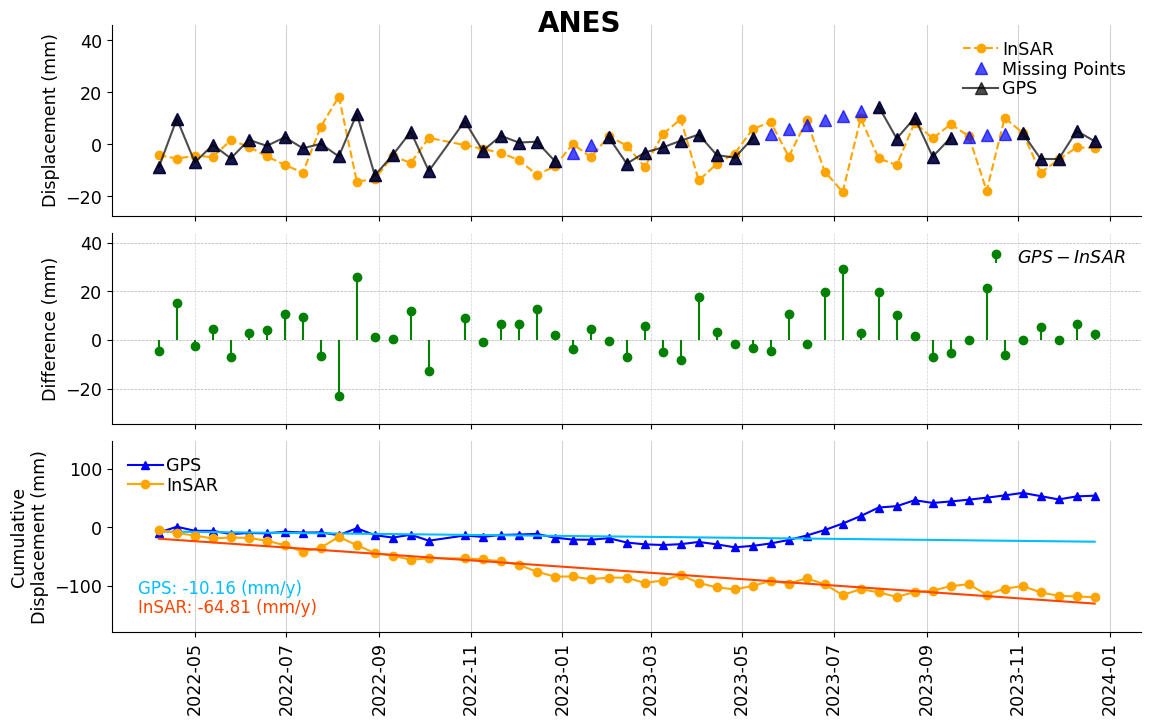

In [3]:
# ------------------------------------------------------------------------------
# Define Paths and Load Sheet Names
# ------------------------------------------------------------------------------
merge_los_fpath = r"E:\030_CHOUSHUI_2024\000_INSCALDEFO_2_INSSTACKPSI\PROCESS_004\14_POST-PROCESSING\InSAR_GPS_LOS_Merge.xlsx"

# Attempt to load the sheet names from the Excel file
try:
    available_sheetnames = get_sheetnames(merge_los_fpath)
except FileNotFoundError as e:
    print(
        f"Error: The file '{merge_los_fpath}' was not found. Please check the path and try again."
    )
    raise
except Exception as e:
    print(f"Error loading sheet names from '{merge_los_fpath}': {e}")
    raise

# Select the first sheet for analysis
select_sheet = available_sheetnames[0]

# ------------------------------------------------------------------------------
# Data Loading and Preparation
# ------------------------------------------------------------------------------
# Attempt to load the data from the specified sheet
try:
    df = pd.read_excel(
        merge_los_fpath, sheet_name=select_sheet, parse_dates=[0], index_col=[0]
    )
except ValueError as e:
    print(
        f"Error: Issue with parsing dates or loading sheet '{select_sheet}' from '{merge_los_fpath}': {e}"
    )
    raise
except Exception as e:
    print(f"Error loading data from sheet '{select_sheet}': {e}")
    raise

# Identify the first valid index for GPS data and slice the DataFrame accordingly
first_valid_idx = df["GPS(mm)"].first_valid_index()
if first_valid_idx is None:
    print("Error: No valid data found in the 'GPS(mm)' column.")
    raise ValueError("No valid data in 'GPS(mm)' column.")

valid_df = df.loc[first_valid_idx:, :]

# Perform interpolation to fill missing values in GPS data
try:
    filled_valid_df = valid_df.interpolate(method="piecewise_polynomial")
except Exception as e:
    print(f"Error during interpolation of GPS data: {e}")
    raise

# Calculate cumulative displacement for the filled valid data
cumdisp_valid_df = filled_valid_df.cumsum()

# Convert cumulative displacement data to include all dates within the range
try:
    fulltime_cumdisp_df = convert_to_fulltime(cumdisp_valid_df)
except Exception as e:
    print(f"Error converting cumulative displacement to full time: {e}")
    raise

# Compute linear trends for GPS and InSAR cumulative displacement
try:
    gps_linear, gps_slope = get_linear_trend(fulltime_cumdisp_df["GPS(mm)"])
    insar_linear, insar_slope = get_linear_trend(
        fulltime_cumdisp_df["InSAR(mm)"]
    )
except KeyError as e:
    print(f"Error: One or more columns not found for trend calculation: {e}")
    raise
except Exception as e:
    print(f"Error calculating linear trends: {e}")
    raise

# Calculate the difference between GPS and InSAR measurements
discrepancy_arr = filled_valid_df["GPS(mm)"] - df["InSAR(mm)"]
discrepancy_arr.name = "Difference(mm)"

# Create a directory to save the figure if it doesn't exist
fig_savefolder = os.path.join(os.getcwd(), "_test_2")
os.makedirs(fig_savefolder, exist_ok=True)

# ------------------------------------------------------------------------------
# Figure and Axes Setup
# ------------------------------------------------------------------------------
# Create a figure and subplots with shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(11.7, 8.3), sharex=True)

# ------------------------------------------------------------------------------
# Plotting Data
# ------------------------------------------------------------------------------
# Plot InSAR and GPS data on the first axis
ax1.plot(
    valid_df.loc[:, "InSAR(mm)"],
    color="orange",
    marker="o",
    linestyle="--",
    label="InSAR",
)
ax1.plot(
    filled_valid_df.loc[:, "GPS(mm)"],
    color="blue",
    marker="^",
    linestyle=" ",
    label="Missing Points",
    ms=8,
    alpha=0.7,
)
ax1.plot(
    valid_df.loc[:, "GPS(mm)"],
    color="black",
    marker="^",
    label="GPS",
    ms=8,
    alpha=0.7,
)

# Plot cumulative displacement on the third axis
ax3.plot(
    cumdisp_valid_df.loc[:, "GPS(mm)"], color="blue", marker="^", label="GPS"
)
ax3.plot(gps_linear, color="deepskyblue")
ax3.plot(
    cumdisp_valid_df.loc[:, "InSAR(mm)"],
    color="orange",
    marker="o",
    label="InSAR",
)
ax3.plot(insar_linear, color="orangered")

# Add text annotations for the slope values
ax3.text(
    0.025,
    0.2,
    f"GPS: {gps_slope*365.25:.2f} (mm/y)",
    transform=ax3.transAxes,
    ha="left",
    va="baseline",
    fontsize=12,
    color="deepskyblue",
)
ax3.text(
    0.025,
    0.1,
    f"InSAR: {insar_slope*365.25:.2f} (mm/y)",
    transform=ax3.transAxes,
    ha="left",
    va="baseline",
    fontsize=12,
    color="orangered",
)

# Plot the difference between GPS and InSAR on the second axis
visualize.plot_stem(
    data=discrepancy_arr,
    xlabel="",
    ylabel="",
    title="",
    ax=ax2,
    linefmt="g-",
    label=r"$GPS - InSAR$",
)

# ------------------------------------------------------------------------------
# Configuration and Customization
# ------------------------------------------------------------------------------
# Configure the y-axis limits for the first subplot
ax1.set_ylim(
    bottom=np.min(filled_valid_df.min()) * 1.5,
    top=np.max(filled_valid_df.max()) * 2.5,
)

ax2.set_ylim(
    bottom=np.min(discrepancy_arr.min()) * 1.5,
    top=np.max(discrepancy_arr.max()) * 1.5,
)

ax3.set_ylim(
    bottom=np.min(cumdisp_valid_df.min()) * 1.5,
    top=np.max(cumdisp_valid_df.max()) * 2.5,
)

# Configure the axis and legend for each subplot
for ax, ylabel in zip(
    [ax1, ax2, ax3],
    ["Displacement (mm)", "Difference (mm)", "Cumulative\nDisplacement (mm)"],
):
    ax.grid(axis="x", which="major", color="lightgrey")
    visualize.configure_axis(ax, ylabel=ylabel, scaling_factor=0.7)
    visualize.configure_legend(ax, scaling_factor=0.7)
    
# ------------------------------------------------------------------------------
# Finalization
# ------------------------------------------------------------------------------
# Adjust layout and add a title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.autofmt_xdate(rotation=90, ha="center")
fig.suptitle(select_sheet, y=0.95, fontsize=20, fontweight="bold")

# Save the figure to the specified path and display it
savepath = os.path.join(fig_savefolder, select_sheet + ".png")

# Attempt to save the figure and handle any errors
try:
    # visualize.save_figure(fig, savepath, dpi=150)
    plt.show()
except IOError as e:
    print(f"Error saving the figure to '{savepath}': {e}")
    raise
except Exception as e:
    print(f"Unexpected error occurred while saving the figure: {e}")
    raise